## GAN

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

in this guide we will cover:

   1)The limitations of generating random samples with a GAN that can be overcome with a conditional generative adversarial network.
 
 2) How to develop and evaluate an unconditional generative adversarial network for generating photos of items of clothing.
  
  3)  How to develop and evaluate a conditional generative adversarial network for generating photos of items of clothing.


## Conditional Generative Adversarial Networks

A generative adversarial network, or GAN for short, is an architecture for training deep learning-based generative models.

The architecture is comprised of a generator and a discriminator model. The generator model is responsible for generating new plausible examples that ideally are indistinguishable from real examples in the dataset. The discriminator model is responsible for classifying a given image as either real (drawn from the dataset) or fake (generated).

A limitation of the Gan model is that it may generate images from the domain.

Alternately, a GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type, or class label, can be generated.


Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information y. […] We can perform the conditioning by feeding y into the both the discriminator and generator as additional input layer.

In case of the MISt dataset, specific hanwritten digits can be generated, in the case of the fashion MNISt dataset, 
sepcific items of clothing can be generated.

This type of model is called a Conditional Generative Adversarial Network, CGAN or cGAN for short.

… by conditioning the model on additional information it is possible to direct the data generation process. Such conditioning could be based on class labels

## designing and training GANS

there have been many advancements in the design and training of GAN models, most notably the deep convolutional GAN, or DCGAN for short, that outlines the model configuration and training procedures that reliably result in the stable training of GAN models for a wide variety of problems. The conditional training of the DCGAN-based models may be referred to as CDCGAN or cDCGAN for short.

There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map.

# Fashion-MNIST Clothing Photograph Dataset

The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset.

It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

In [21]:
import tensorflow as tf
import keras
from matplotlib import pyplot

In [18]:

# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('bTest', testX.shape, testy.shape)

4431872/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
bTest (10000, 28, 28) (10000,)


In [ ]:
#output:
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)

images are b&w with a black background, and the items of clothing are in white. So images are moslty black with a white item of clothing in the middle.


it is however easier to view them if we invert the colours so that the background is white and the images are in grey scale

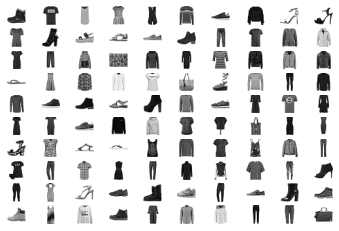

In [24]:
# plot raw pixel data

from keras.datasets.fashion_mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
# define subplot
    pyplot.subplot(10, 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')


# Unconditional GAN for Fashion-MNIST

developing an unconditional Gan for the fanshion MNIST dataset.

step one is to define the model:
    
        
    
 The discriminator model takes as input one 28×28 grayscale image and outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). 
 It is a convolutional network that uses the the LeakyReLU activation function with a slope of 0.2, using a 2×2 stride to downsample, and the adam version of stochastic gradient.
 
 
 The define_generator function defines and compiles the discriminator model and returns it: the imput shape is parametrised as a default funct argument so that this function can be reused with other images later:
 

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

The generator model takes as input a point in the latent space and outputs a single 28×28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7×7).

This is then upsampled twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the LeakyReLU activation, a kernel size that is a factor of the stride size, and a hyperbolic tangent (tanh) activation function in the output layer.

The define_generator() function below defines the generator model, but intentionally does not compile it as it is not trained directly, then returns the model. The size of the latent space is parameterized as a function argument.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

Next, we define a a GAN model taht combines both the gen model and the discriminator model into one larger model.

This is the model that will be used to train the model weights in the generator:

we use the output and the error calcualted by the discriminator model.

The discriminator model is trained separately, and this is because the model weights are not trainable in this larger GAN model. We just want tthe weights of the generator model to be updated:
this change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

### summarising


the discriminator model takes an image and decides wether it is a real image or a fake one. 

The define generetator model is used to generate a 28x28 grey scale image.

The Gan model combines these two models into a larger model. The weights of the discrimiator model are trained separately , and as such are marked as not trainable in this combined model 


The GAN model takes an input point in space, and uses then generator model to generate an image.
This image is then fed into the discriminator model and the output is classified as real or fake.

Here is the define_gan() function

In [ ]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Preprocessing of the FASHION MNIST dataset

first we take our images and another dimension to transform them to be three dimensional, as expected by the convolutional layers of our models, and scale the pixel values to the range [-1,1] to match the output of the generator model:

In [ ]:
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

We need one batch (or a half) batch of real images from the dataset each update to the GAN model. 

To do this, we select a random sample of images from the dataset each time.



The generate_latent_points() function implements this, taking the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

These points are now ready to be fed into our generator model to create new images!

The generate_fake_samples() function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. 

The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated.

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

# Fitting the GAN models

we train the model for an arbitrary number of epochs (here we went with 100).

The batch size is 128 and each training epoch involves 60,000/128, or about 468 batches of real and fake samples and updates to the model.

The dsiscriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates.

The generator is then updated via the composite gan model. 

IMPORTANT!!!: the class label is set to 1 or real for the fake samples! This has the effect of updating the generator toward getting better at generating real samples on the next batch.

The train() function below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('generator.h5')

We can then define the size of the latent space, define all three models, and train them on the loaded fashion MNIST dataset.

In [ ]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

# Understanding the Metrics of GANS

## Inception score

the first metric introduced is the Inception score.
It attempts to capture both the quality of the images as well as the diversity if the samples created.

So it captures 2 attributes of a generative model: the qualtiy of the image and the range 
of imaged that we care about.
For example, we would not want in the MNIST  (hand written no dataset)
case a model that only generates 4(s) when we have all teh numbers 1 through 9 in our dataset.

The back bone of the inception score is a pretrained classifier called the inception network

this IS(G) has the task of taking an image and spitting out a distribution over all possible outcomes (like all classifiers)

The formula is:

IS(G) = exp(E_{x~pa} D_{KL}(Py|x)||p(y)))



p(y|x) is Inception's likelihood that image x is class y.
Expectation is taken over distribution p(y) which is estimated by a large minibatch. (often the minibatch is of size 1000)

D_{KL} is a notion of distributional similarity. DK stans for the kl divergence, which captures the difference between different distributiions.


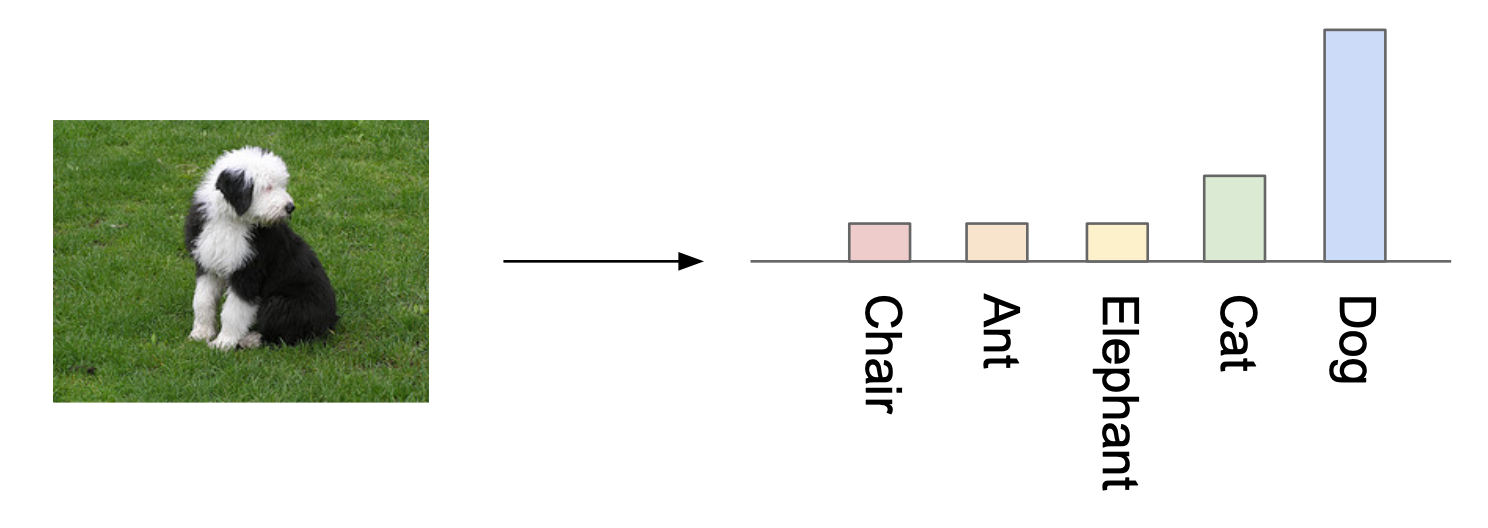

In [5]:
from IPython import display 
display.Image("gans_metric.png")

For a well trained classifier, if given a crisp image like the one above, it shoulld
feel pretty certain that the image that is fed into it is a dog.
hence why the distribution is peaking at "dog". The entwork is confident that this image
is a dog, and is not any of the other classes.
Hence we would say that this is a LOW ENTROPY DISTRIBUTION


But if we feed it a blurry low quality picture, suddenly the distirbution is much more un
uniform with no significant peaks because the network is unsure which of these categories the image belongs to. Hence we would say that this is a HIGH ENTROPY DISTRIBUTION.

Thus in some sense, by looking at the entropy of the distribution, we can capture some notion of image quality.

Ideally we would like high quality images that produce low entropy values when fed into the  Inception network.



If we were to feed the network a set of crisp  and clear dog images, and would sum up all the ditributions, the overall sum would result in a distribution that peaks at the dog
category, and is quite low value every where else. This is because the network is very 
sure that all the images that has been fed into it are all dog images.




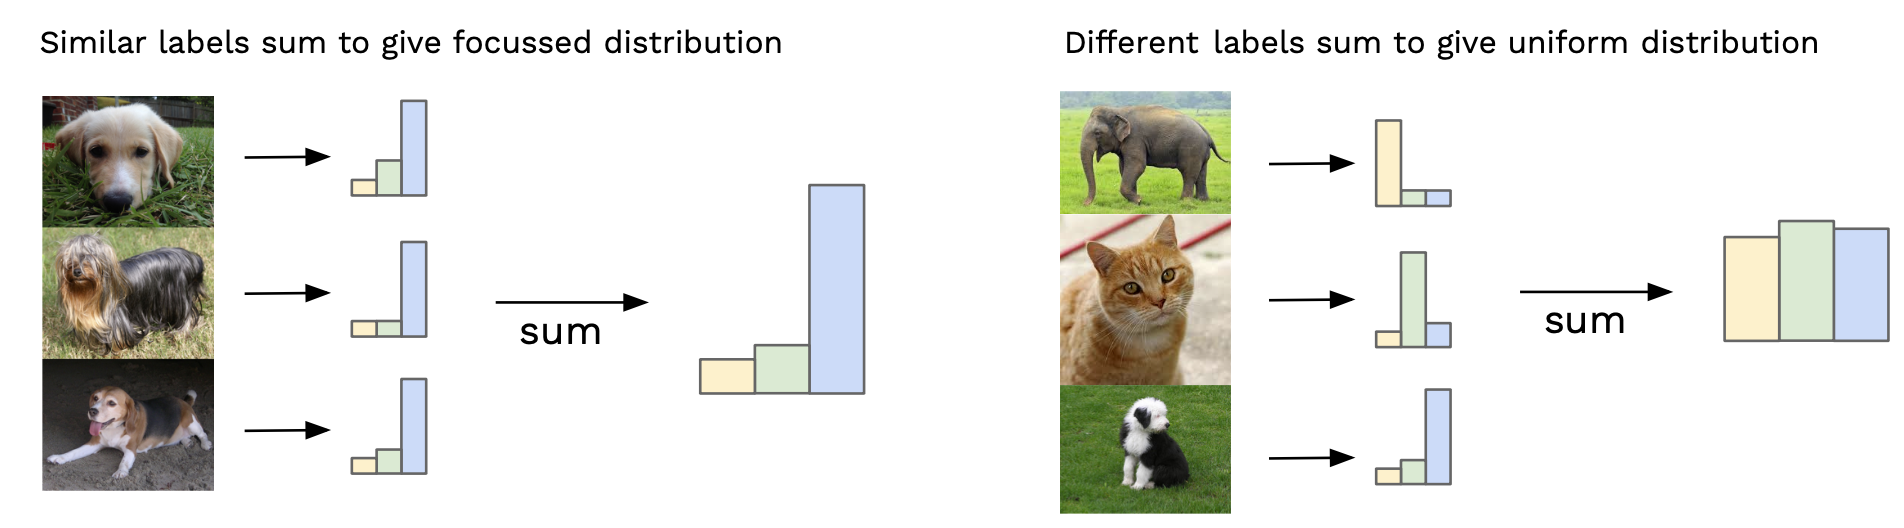

In [8]:
display.Image("average.png")

If we were to feed it a bunch of pictures that are not all dogs (say a variety of animal pictures), and asked it to sum over all the distributions and create a cumulative distribution, this overall distribution would have no significant peaks and also have a high entropy. Maybe for each picture the network has a very low entropy distribution, asn it can confidently identify all these pictures "independently". But when all these distrubtion are summed together, the resulting one will have a higher entropy because when taken together
he network sees a lot of pictures of things that are not dogs, and thus cannot predict confidently that any image belonging to the set of images it has been fed is a dog.



So this tells us that what we want is that the * individual* distributions of images to have a LOW ENTROPY 
and the average distribution of all the images to have a very HIGH ENTROPY because this indicates that the set of data we have fed the network is quite diverse.


There is an inception score that is openly available on github on the tensorflow account. You can install it using the pip package installer, and read about the evaluation metrics here.


https://github.com/tensorflow/gan/tree/master/tensorflow_gan/python

### limitations of the inception score:

   The score is limited by what the Inception (or other network) classifier can detect, which is directly linked to the training data (commonly ILSVRC 2014). This has a few repercussions:
    
   (1) If you’re learning to generate something not present in the classifier’s training data (e.g. sharks are not in ILSVRC 2014) then you may always get low IS despite generating high quality images since that image doesn’t get classified as a distinct class
   
   (2) If you’re generating images with a different set of labels from the classifier training set (say, you’re training the GAN to generate different varieties of poodles, or just elephants and ants) it can score lowly
   
   (3) If the classifier network cannot detect features relevant to your concept of image quality (e.g. there is evidence that CNNs rely heavily on local image textures for classification, and coarse shapes do not matter so much), then poor quality images may still get high scores. For example, you might generate people with two heads, but not get penalized for it.
 
 (4)If your generator generates only one image per classifier image class, repeating each image many times, it can score highly (i.e. there is no measure of intra-class diversity)
    If your generator memorizes the training data and replicates it, it can score highly

# Frechet inception Distance

This metric is an improvement over the inception score.

Is more mathematically motivated in its theory.

The Frechet inception distance is a comparison between two different distributions of images.
We use the collection of real images that we have to do this comparison .



This is the formula:

d^2 = ||mu_1 – mu_2||^2 + Tr(C_1 + C_2 – 2*sqrt(C_1*C_2))

The “mu_1” and “mu_2” refer to the feature-wise mean of the real and generated images, e.g. 2,048 element vectors where each element is the mean feature observed across the images.

The ||mu_1 – mu_2||^2 refers to the sum squared difference between the two mean vectors. 

Tr is just the trace operator in linear algebra that gives you the trace of the matrix


The C_1 and C_2 are the covariance matrix for the real and generated feature vectors, often referred to as sigma.

### intuitvely understanding the Frechet distance 

Imagine a person traversing a finite curved path while walking their dog on a leash, with the dog traversing a separate finite curved path. Each can vary their speed to keep slack in the leash, but neither can move backwards. The Fréchet distance between the two curves is the length of the shortest leash sufficient for both to traverse their separate paths from start to finish. Note that the definition is symmetric with respect to the two curves—the Fréchet distance would be the same if the dog were walking its owner. 

So from this concept the frechet distance between two multivariate normal distributions having means mu_x and mu_y and covariances sigma_x and sigma_y  is shown to vbe the formula 

d^2 = ||mu_x – mu_y||^2 + Tr(C_1 + C_2 – 2*sqrt(C_1*C_2))


Thus the Frechet inception distance answers the question: if inception probabilities for real andn fake images are modeled as Gaussians.

# Loading and saving models

In [ ]:

## (An aside on saving and loading models)

to learn and understand how to load and save models once they have been trained, tensorflow provides a very easy and quick tutorial to follow here, which is definitely worth consulting:

https://www.tensorflow.org/tutorials/keras/save_and_load

### Save the entire model (in the case of the example above)

Call model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x. However, models can be saved in HDF5 format. More details on saving entire models in the two file formats is described below.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

In [ ]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()


In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


Keras saves models by inspecting their architectures. This technique saves everything:

    The weight values
    The model's architecture
    The model's training configuration (what you pass to the .compile() method)
    The optimizer and its state, if any (this enables you to restart training where you left off)


Saving custom objects

If you are using the SavedModel format, you can skip this section. The key difference between HDF5 and SavedModel is that HDF5 uses object configs to save the model architecture, while SavedModel saves the execution graph. Thus, SavedModels are able to save custom objects like subclassed models and custom layers without requiring the original code.

To save custom objects to HDF5, you must do the following:

    Define a get_config method in your object, and optionally a from_config classmethod.
        get_config(self) returns a JSON-serializable dictionary of parameters needed to recreate the object.
        from_config(cls, config) uses the returned config from get_config to create a new object. By default, this function will use the config as initialization kwargs (return cls(**config)).
    Pass the object to the custom_objects argument when loading the model. The argument must be a dictionary mapping the string class name to the Python class. E.g. tf.keras.models.load_model(path, custom_objects={'CustomLayer': CustomLayer})

See the Writing layers and models from scratch tutorial for examples of custom objects and get_config.